# Metrics learning. Практика.

В данном задании нам предстоит кластеризовать клиентов банка по характеру финансового поведения с продуктом банка (кредитная карта). 

## Загрузим необходимые данные и библиотеки

In [81]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

In [83]:
data = pd.read_csv('data/CC_GENERAL.zip')
data

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

## Обработка данных

Посмотрим на статистики, вызвав метод desribe.

In [85]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


Видим много выбросов, постараемся избавится от них, сделав диапазоны значений для различных колонок.

## Работа с пропусками

In [86]:
data.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [87]:
hd.get_columns_null_info_df(data)

,Column Name,Count Null,% Null,Type
0,CREDIT_LIMIT,1,0.01,float64
1,MINIMUM_PAYMENTS,313,3.50,float64


### Задание 8.1
Выведите количество пропусков. количество пропусков в признаке `MINIMUM_PAYMENTS` используйте как ответ на задание 8.1

In [88]:
data['MINIMUM_PAYMENTS'].isna().sum()

313

Заполните значения `MINIMUM_PAYMENTS`, `CREDIT_LIMIT` средним значением:

In [89]:
# data.loc[data['MINIMUM_PAYMENTS'].isnull(), 'MINIMUM_PAYMENTS'] = data['MINIMUM_PAYMENTS'].mean()
# data.loc[data['CREDIT_LIMIT'].isnull(), 'CREDIT_LIMIT'] = data['CREDIT_LIMIT'].mean()

In [90]:
# Так лучше заполнять
values = {
    'MINIMUM_PAYMENTS': data['MINIMUM_PAYMENTS'].mean(),
    'CREDIT_LIMIT': data['CREDIT_LIMIT'].mean()
}
data.fillna(values, inplace=True)

Проверим еще раз, что пропусков более нет

In [91]:
data.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [92]:
hd.get_columns_null_info_df(data)

'No one null values!'


## Работа с выбросами

Для работы с выбросами сделаем диапазоновые значения признаков, для этого будем использовать функцию

In [93]:
def add_range(df, columns, range_list, onesided=True):
    for column in columns:
        name = column + '_range'
        df[name] = 0
        for i in range(len(range_list) - 1):
            df.loc[(df[column] > range_list[i]) & (df[column] <= range_list[i + 1]), name] = i + 1
            if onesided:
                df.loc[(df[column] > range_list[-1]), name] = len(range_list)
    df.drop(columns, axis=1, inplace=True) # удаление исходных столбцов

In [94]:
add_range(data, ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
        'PAYMENTS', 'MINIMUM_PAYMENTS'], [0, 500, 1000, 3000, 5000, 10000])

In [95]:
add_range(data, ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 
         'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT'] , np.linspace(0, 1, 11), onesided=False)

In [96]:
add_range(data, ['PURCHASES_TRX', 'CASH_ADVANCE_TRX'], [0, 5, 10, 15, 20, 30, 50, 100], onesided=False)

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   CUST_ID                                 8950 non-null   object
 1   TENURE                                  8950 non-null   int64 
 2   BALANCE_range                           8950 non-null   int64 
 3   PURCHASES_range                         8950 non-null   int64 
 4   ONEOFF_PURCHASES_range                  8950 non-null   int64 
 5   INSTALLMENTS_PURCHASES_range            8950 non-null   int64 
 6   CASH_ADVANCE_range                      8950 non-null   int64 
 7   CREDIT_LIMIT_range                      8950 non-null   int64 
 8   PAYMENTS_range                          8950 non-null   int64 
 9   MINIMUM_PAYMENTS_range                  8950 non-null   int64 
 10  BALANCE_FREQUENCY_range                 8950 non-null   int64 
 11  PURC

In [98]:
# Удаление признака т.к. он не несет никакой смысловой нагрузки, просто номер клиента в базе
data.drop(columns='CUST_ID', inplace=True)

### Стандартизация данных

In [99]:
scale = StandardScaler()
X = scale.fit_transform(data)
X.shape

(8950, 17)

Определимся с количеством кластеров

### Задание 8.2
Используя `KElbowVisualizer` из модуля `yellowbrick.cluster` определите оптимальное количество кластеров. Для этого на вход `KElbowVisualizer` подайте модель `Kmeans`, максимальное количество кластеров следует ограничить до `k=20`. Ответом на задание является количество кластеров. 

In [100]:
from yellowbrick.cluster import KElbowVisualizer

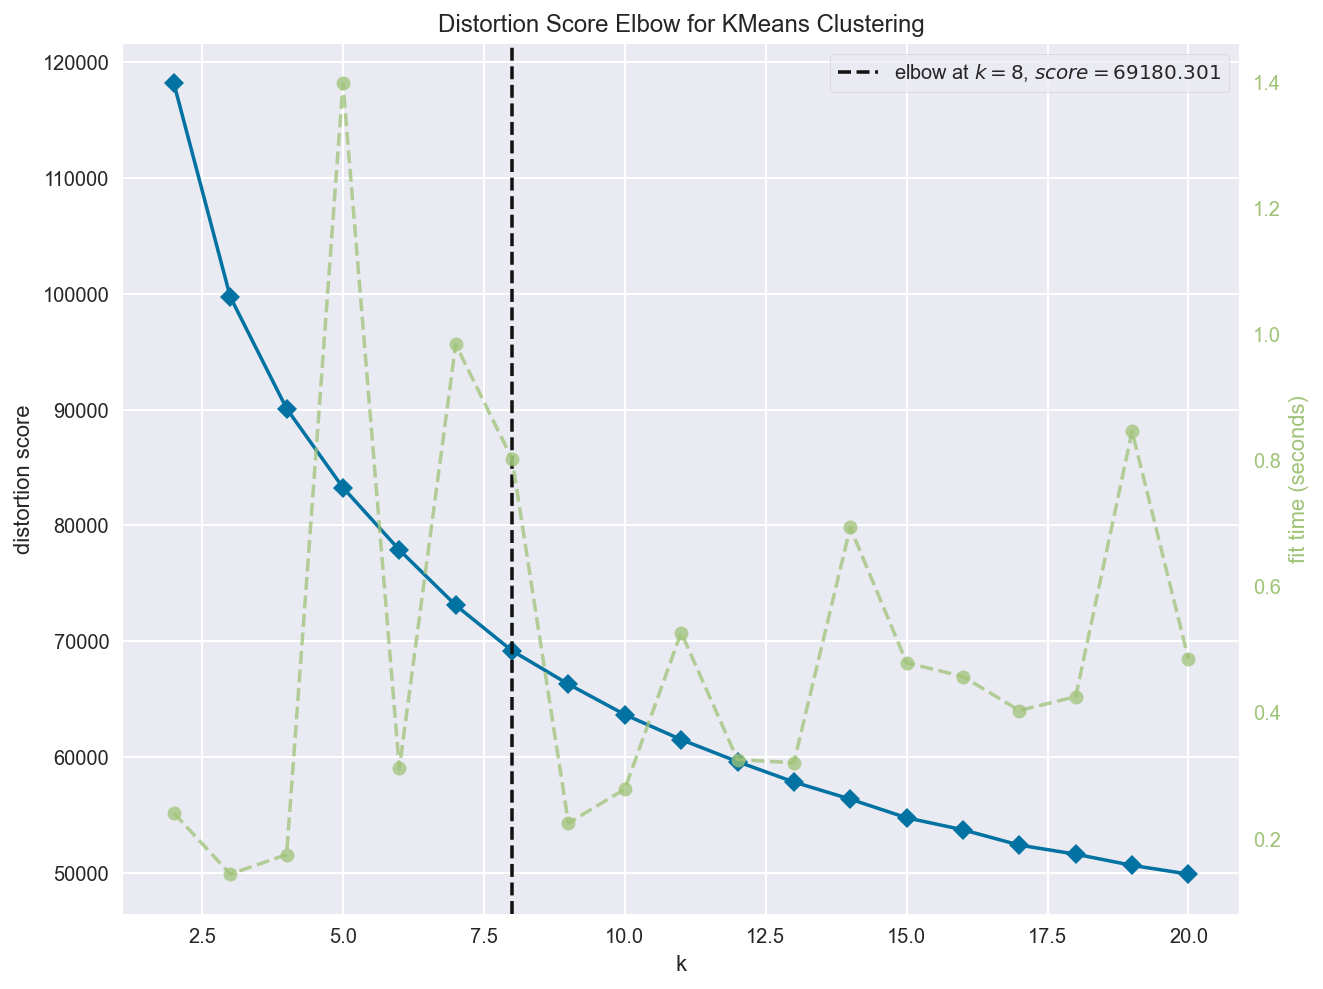

In [101]:
Elbow_M = KElbowVisualizer(KMeans(), k=20)
Elbow_M.fit(X)
Elbow_M.show();

Для корректной работы в дальнейшем предлагается внести ответ в качестве переменной

In [102]:
k_clust = 8 # сюда вставить ответ на задачу 8.2

## Кластеризация

Обучите модель `Kmeans` с количеством кластеров, полученном в задании 6.2, с помощью метода

In [103]:
kmean = KMeans(k_clust)
kmean.fit(X) 
labels = kmean.labels_

In [104]:
clusters = data.copy() # Коприрую исходный датафрейм
clusters['cluster'] = labels # В новый датафрейм добавляю столбец с результатами кластериации

In [105]:
# Верхний вариант получения нового датафрейма с признаком меток классов мне нравится больше
# clusters = pd.concat([data, pd.DataFrame({'cluster': labels})], axis=1)
# clusters

## Анализ результатов кластеризации

In [106]:
clusters

,TENURE,BALANCE_range,PURCHASES_range,ONEOFF_PURCHASES_range,INSTALLMENTS_PURCHASES_range,CASH_ADVANCE_range,CREDIT_LIMIT_range,PAYMENTS_range,MINIMUM_PAYMENTS_range,BALANCE_FREQUENCY_range,PURCHASES_FREQUENCY_range,ONEOFF_PURCHASES_FREQUENCY_range,PURCHASES_INSTALLMENTS_FREQUENCY_range,CASH_ADVANCE_FREQUENCY_range,PRC_FULL_PAYMENT_range,PURCHASES_TRX_range,CASH_ADVANCE_TRX_range,cluster
0,12,1,1,0,1,0,2,1,1,9,2,0,1,0,0,1,0,3
1,12,4,0,0,0,5,5,4,3,10,0,0,0,3,3,0,1,5
2,12,3,2,2,0,0,5,2,2,10,10,10,0,0,0,3,0,3
3,12,3,3,3,0,1,5,0,2,7,1,1,0,1,0,1,1,3
4,12,2,1,1,0,0,3,2,1,10,1,1,0,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,6,1,1,0,1,0,2,1,1,10,10,0,9,0,5,2,0,1
8946,6,1,1,0,1,0,2,1,2,10,10,0,9,0,0,2,0,1
8947,6,1,1,0,1,0,2,1,1,9,9,0,7,0,3,1,0,1
8948,6,1,0,0,0,1,1,1,1,9,0,0,0,2,3,0,1,1


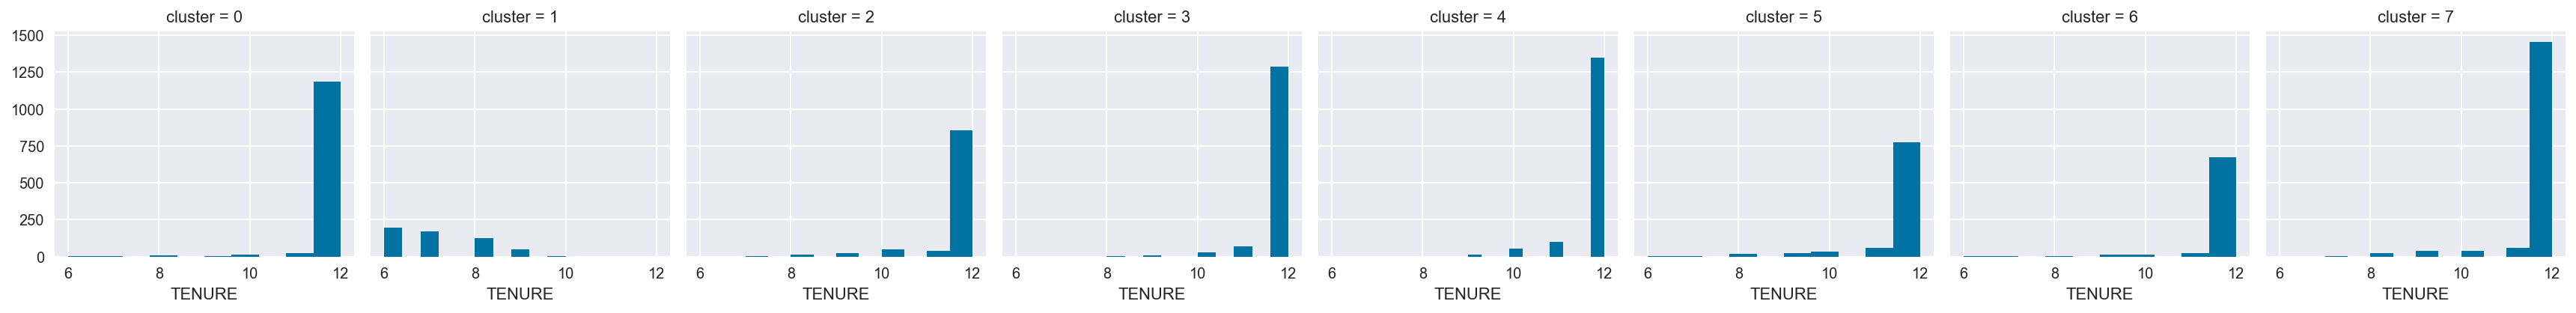

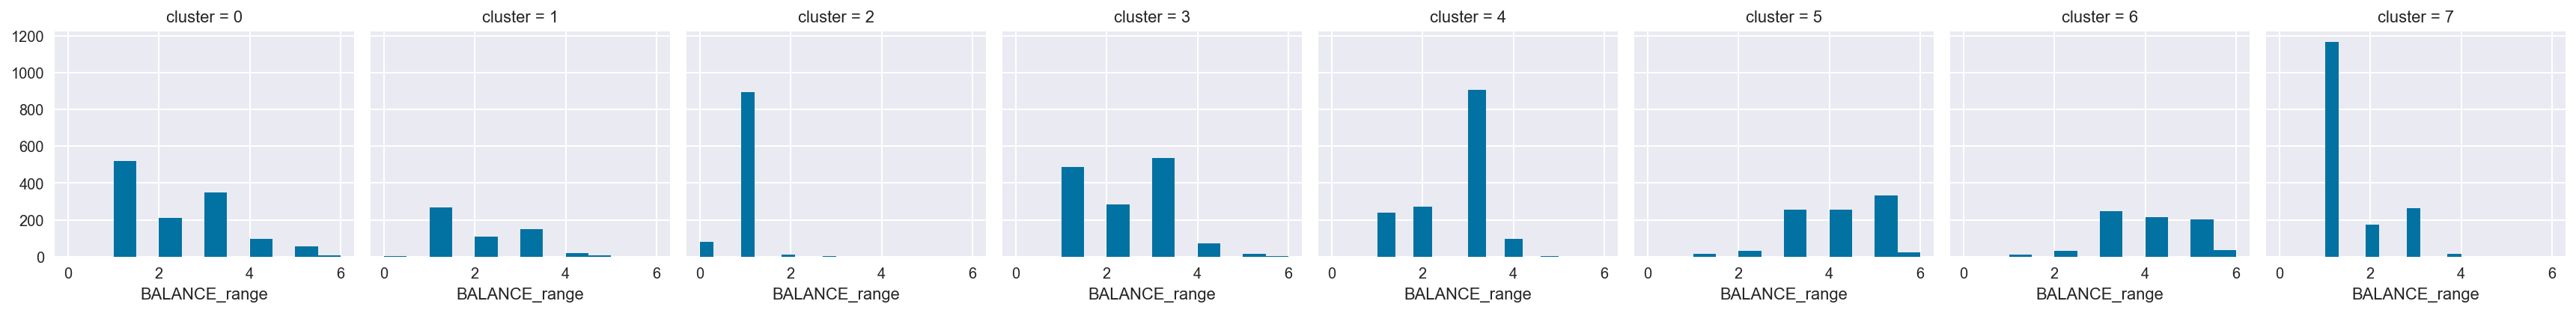

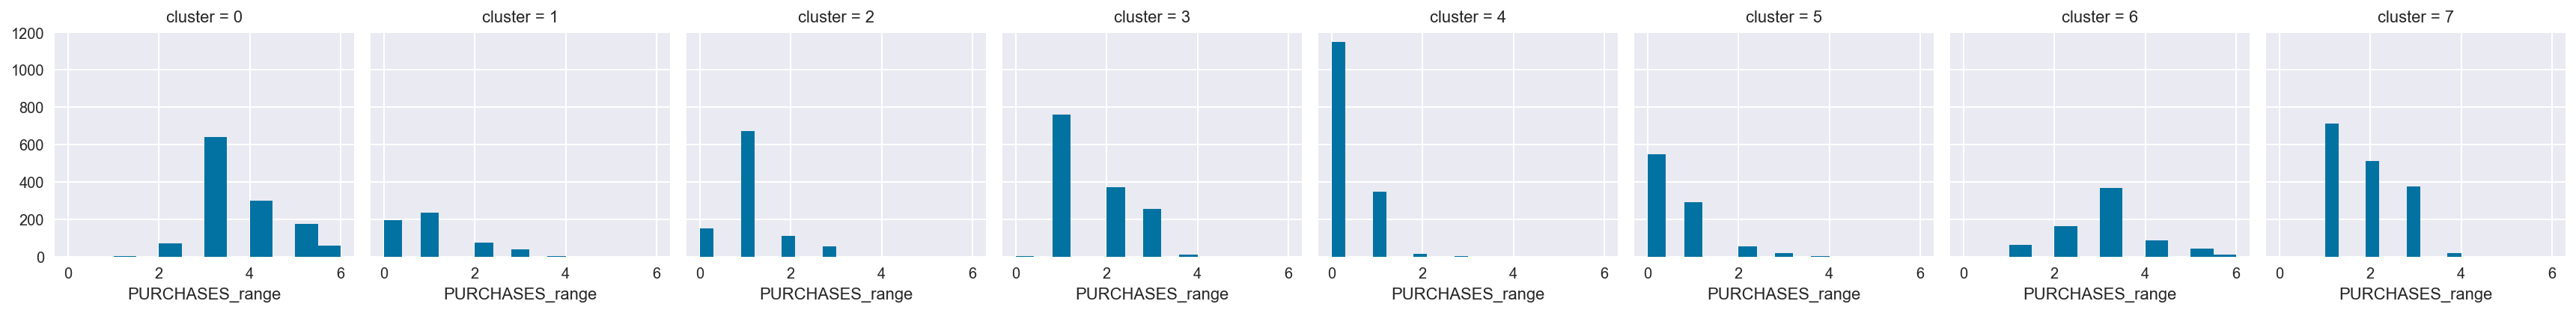

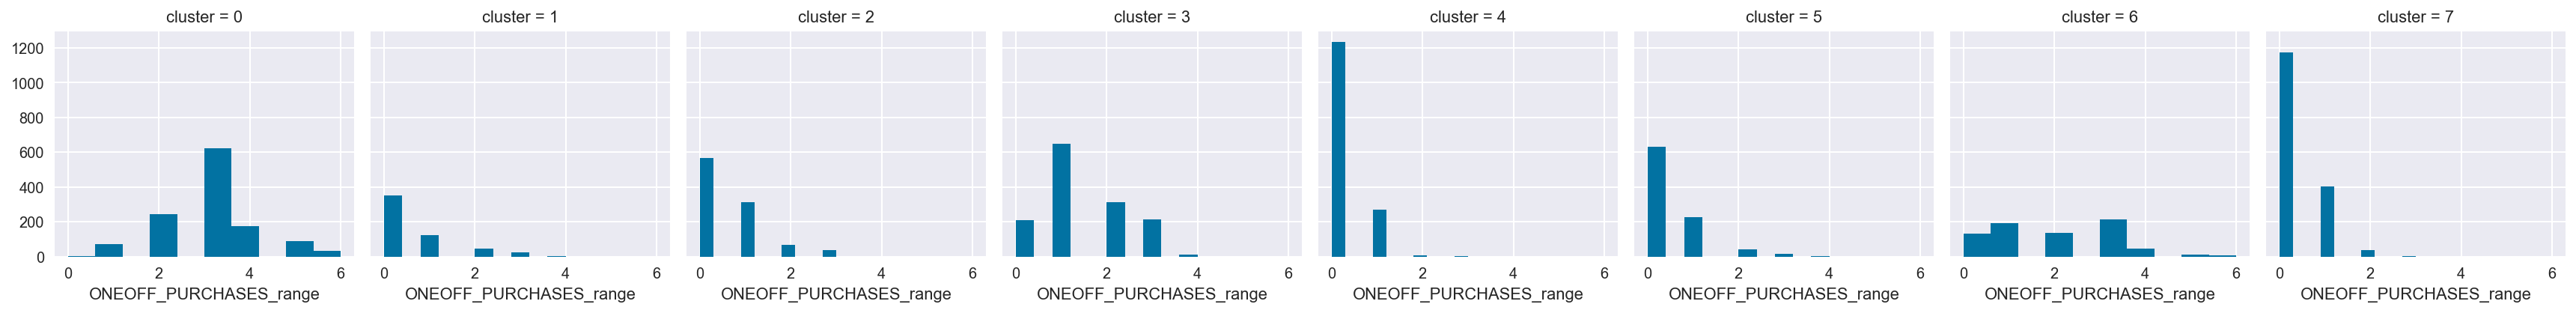

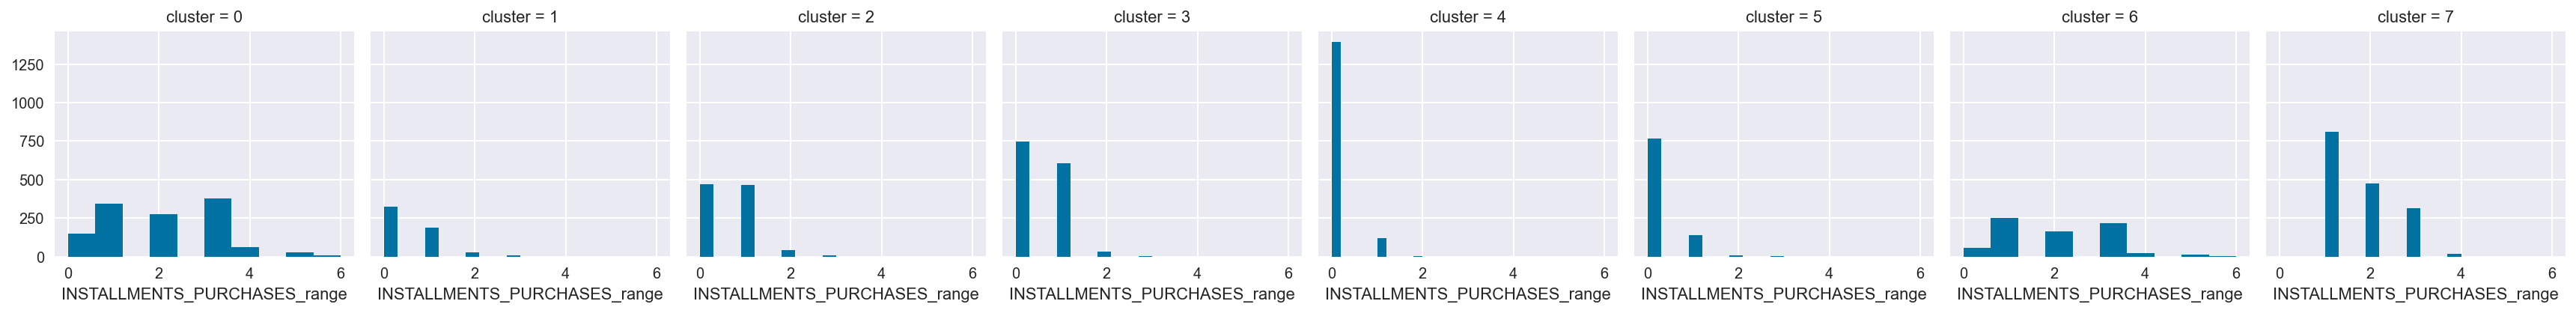

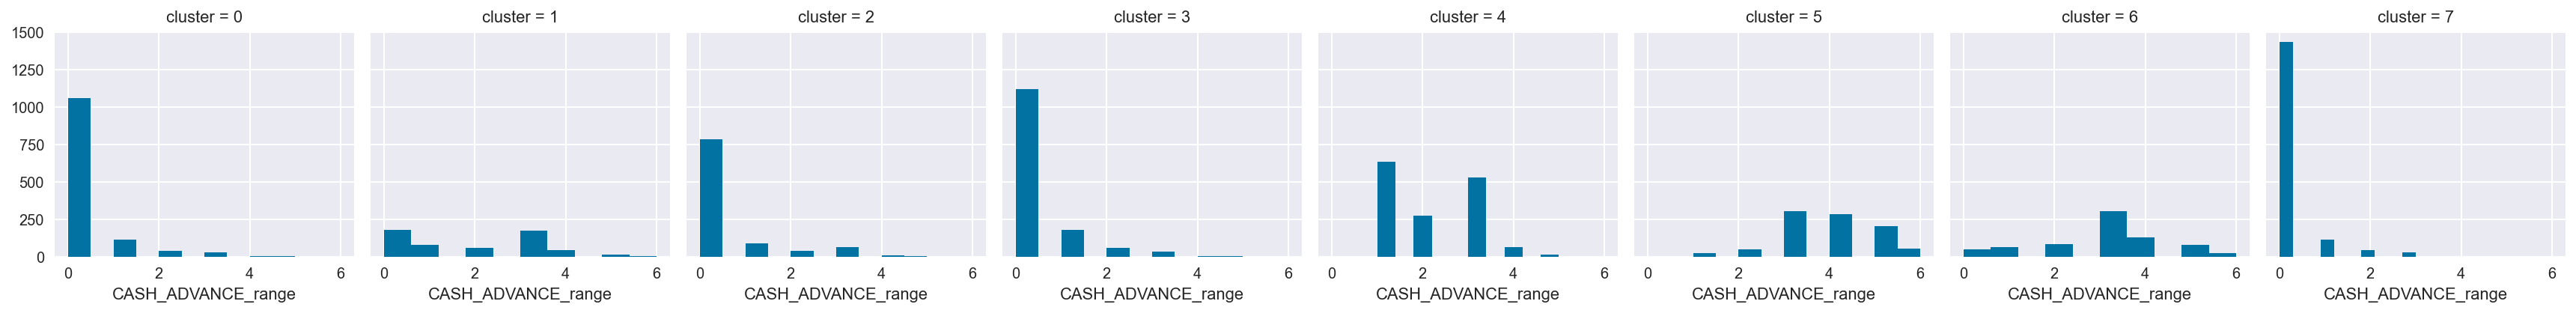

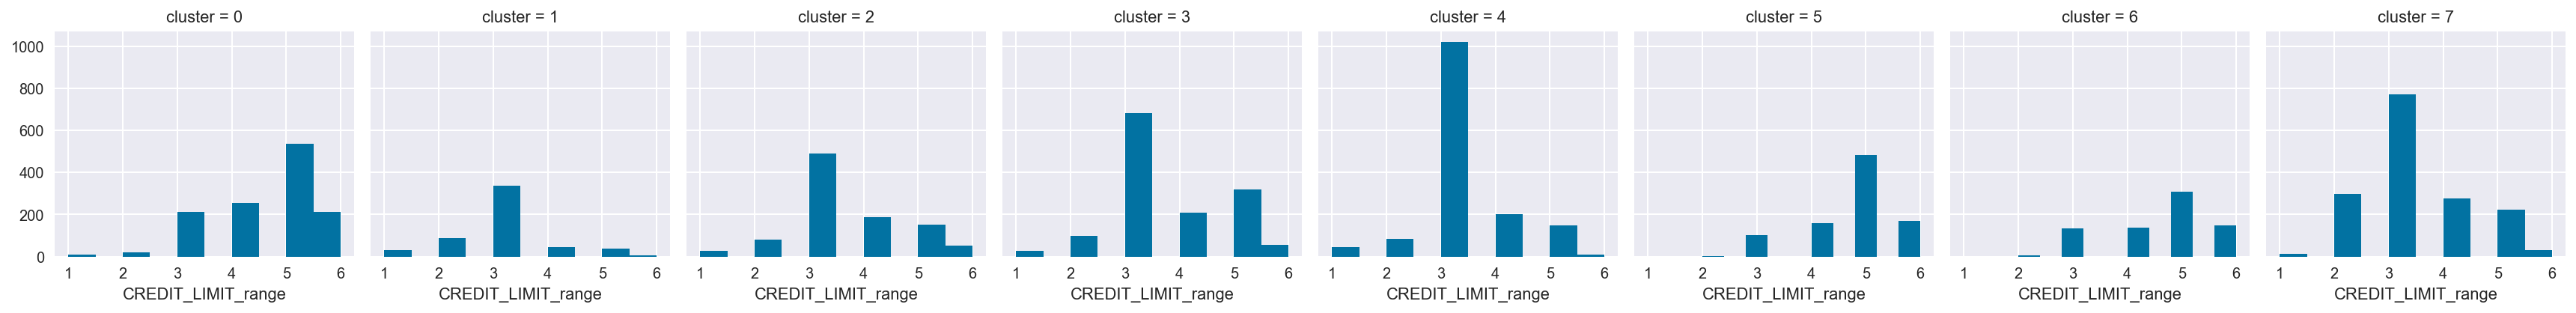

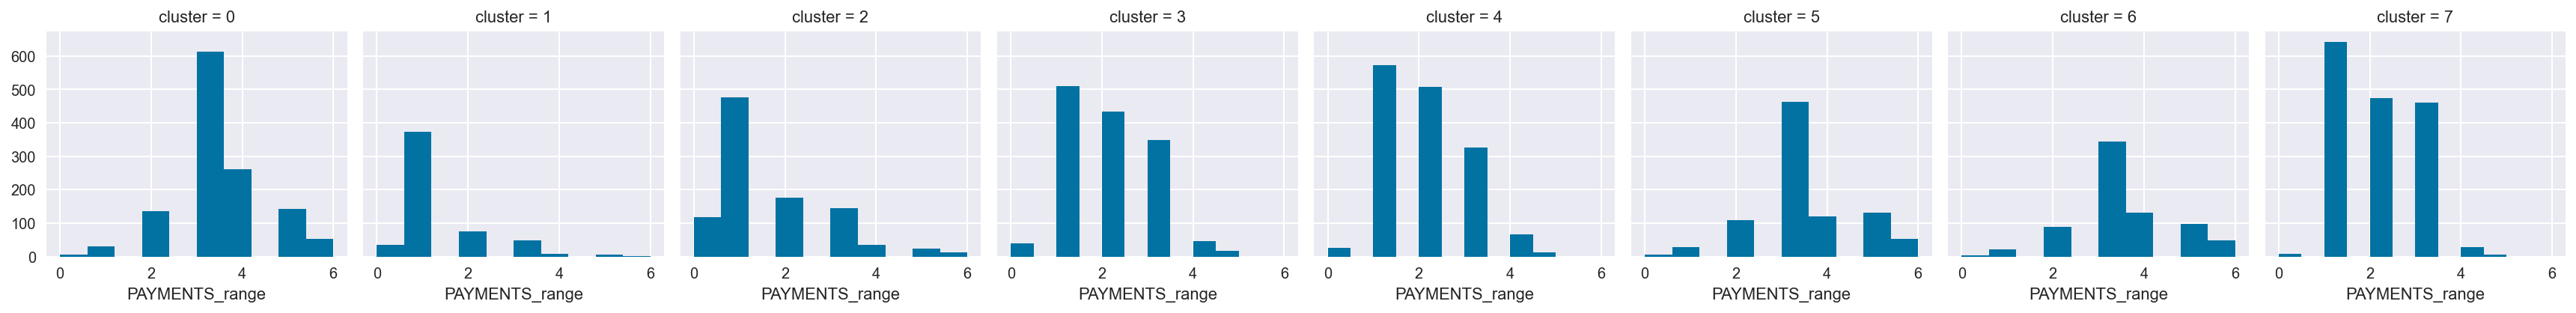

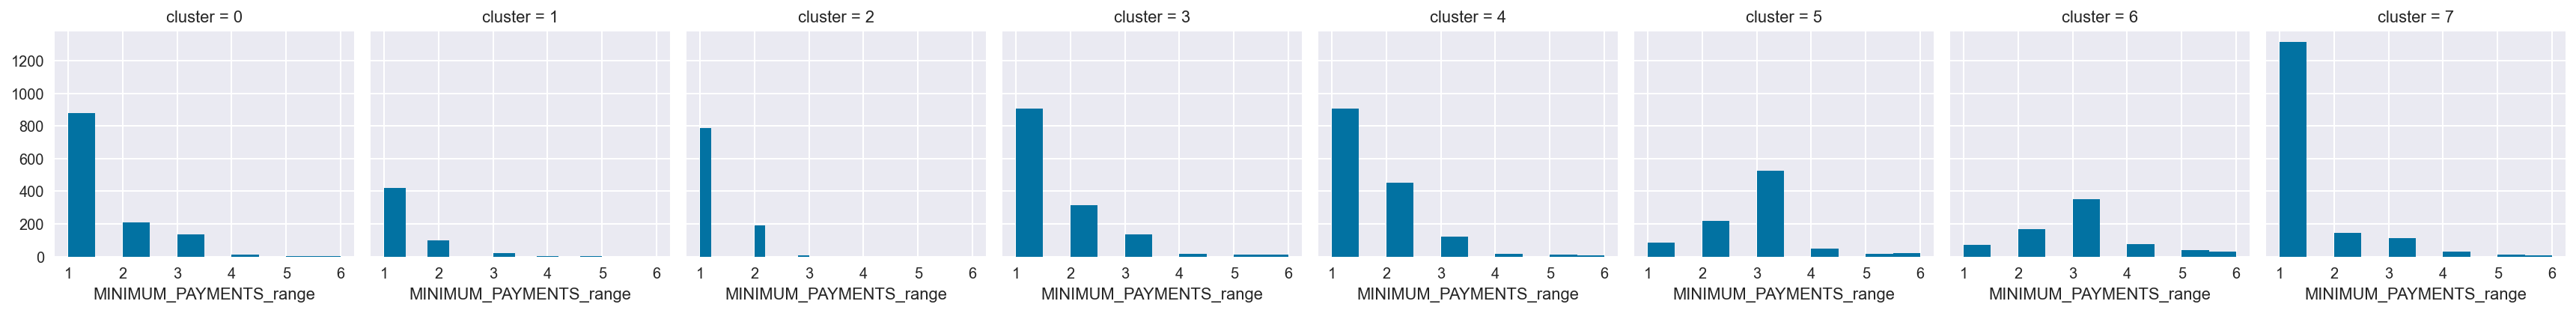

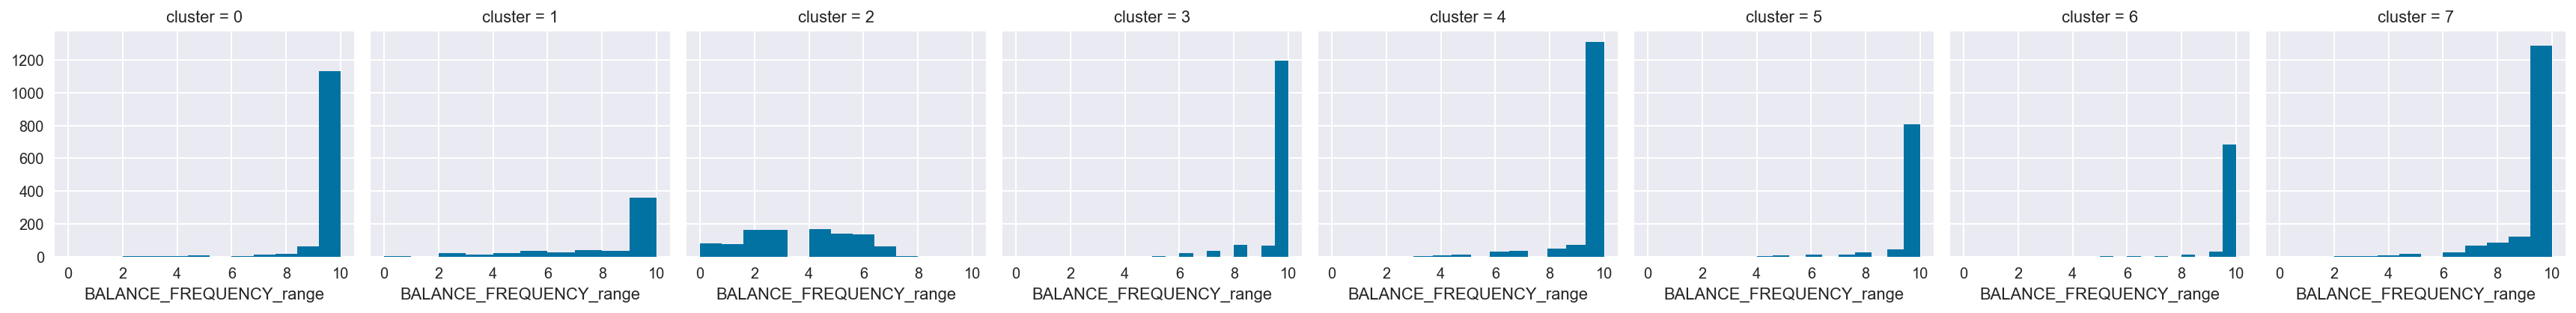

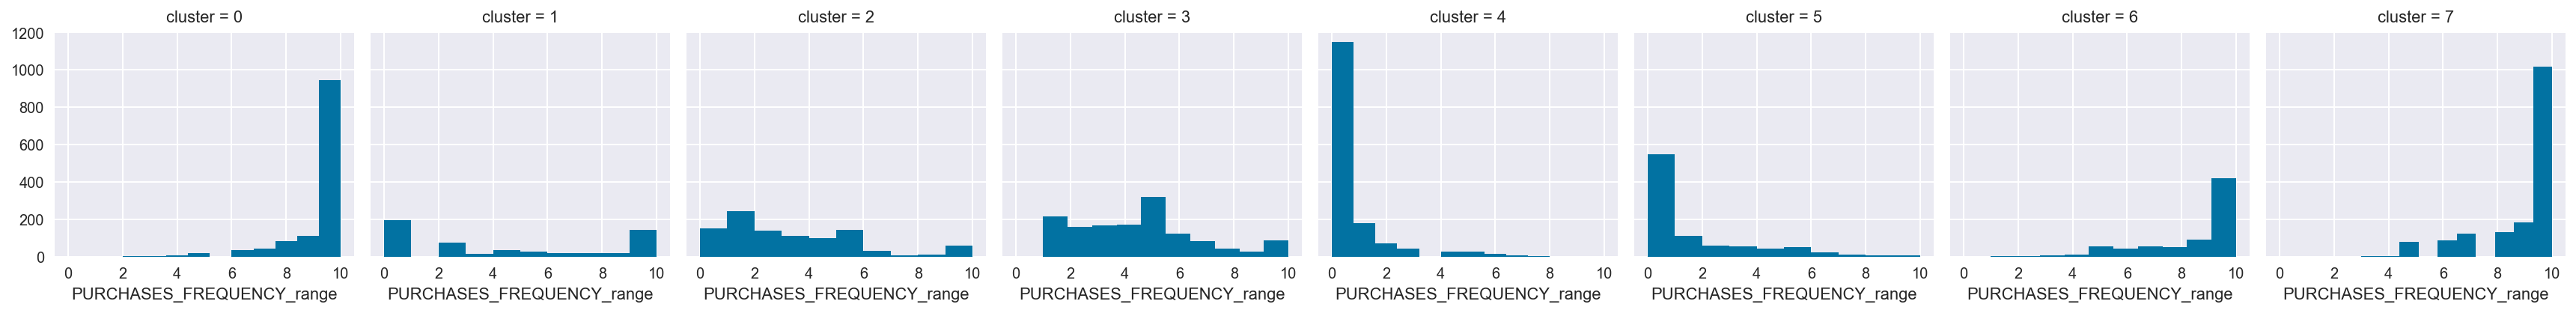

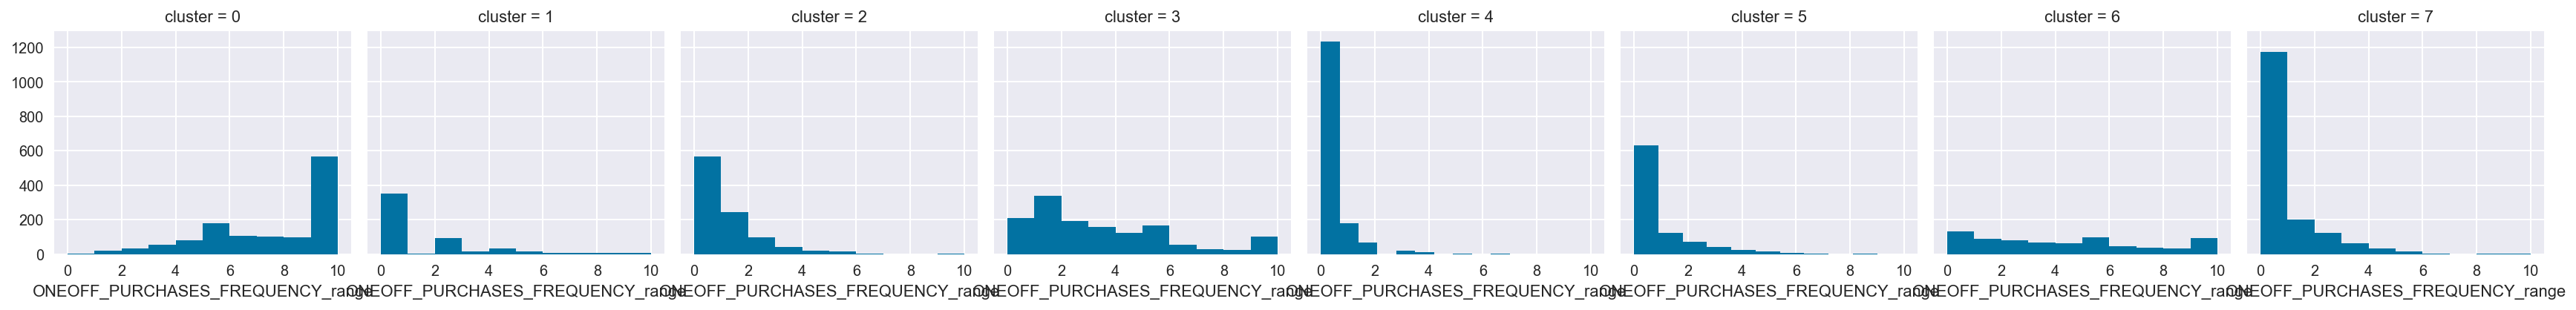

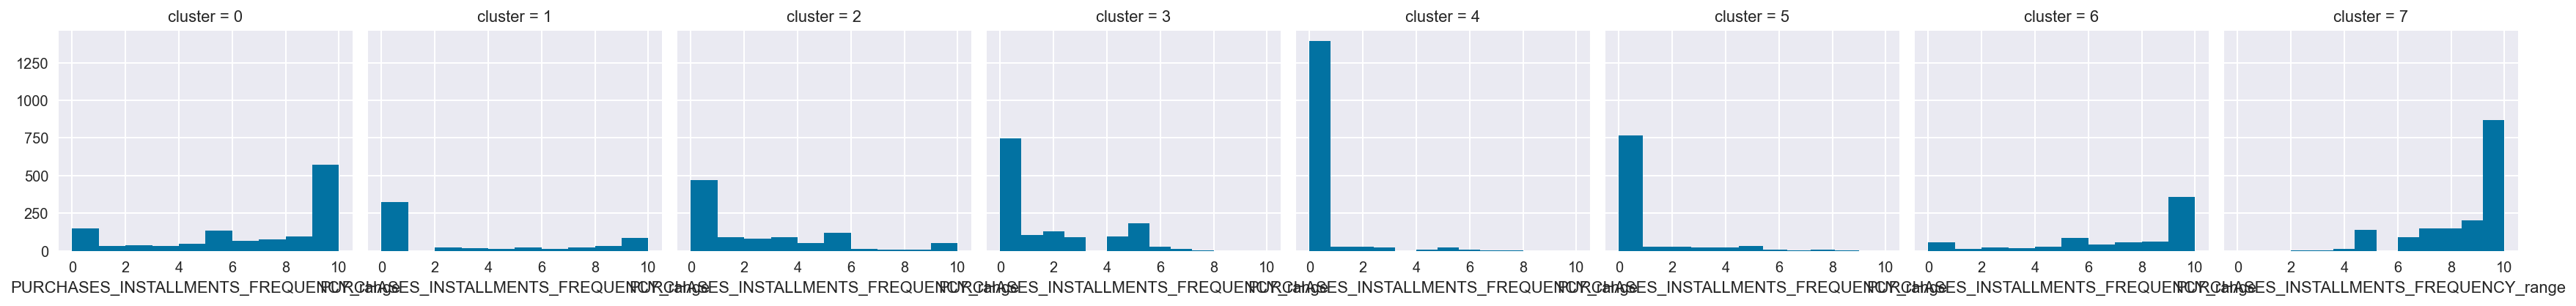

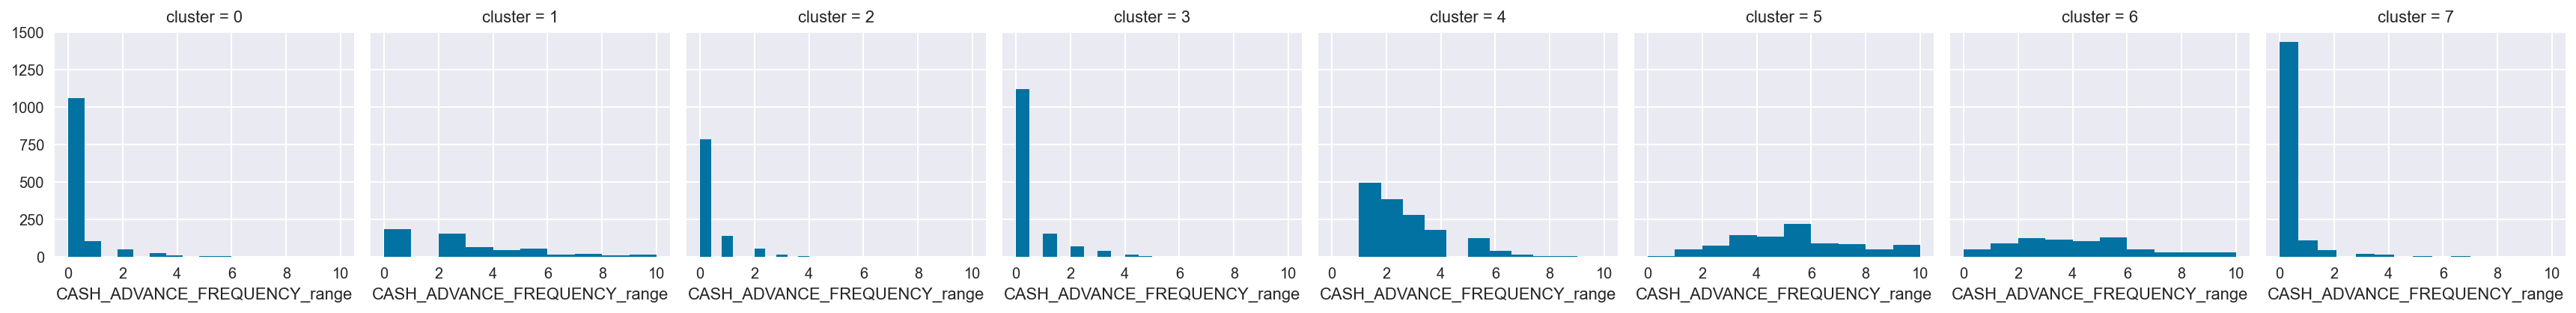

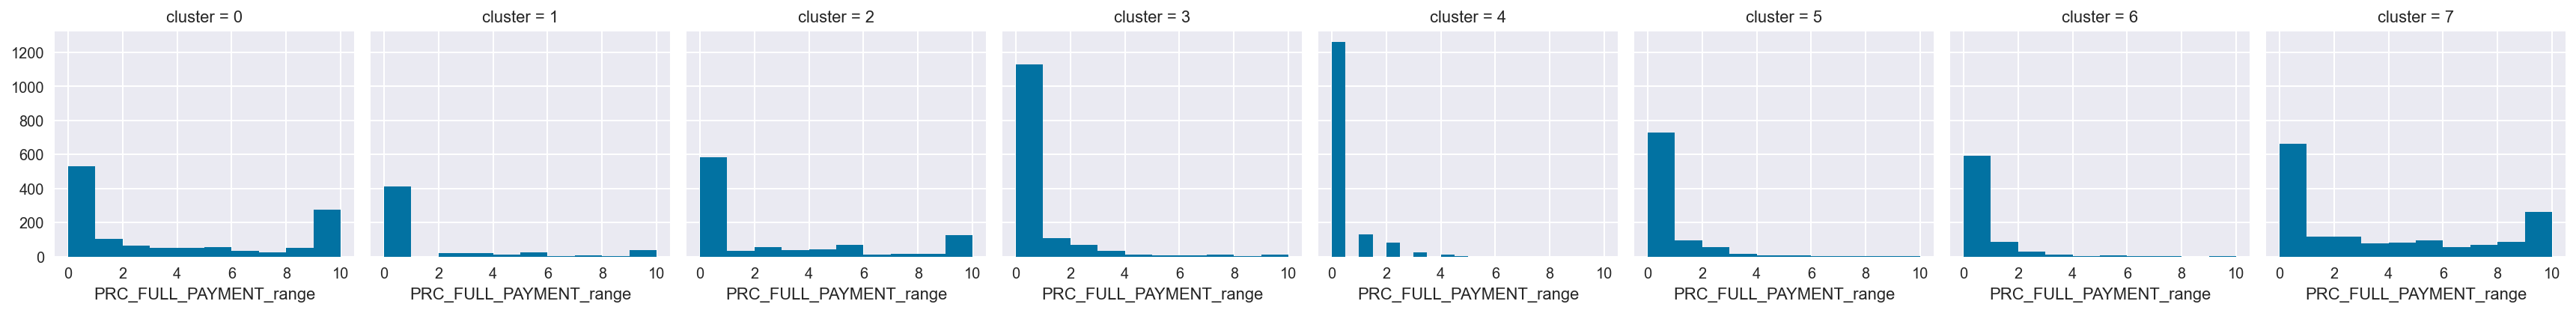

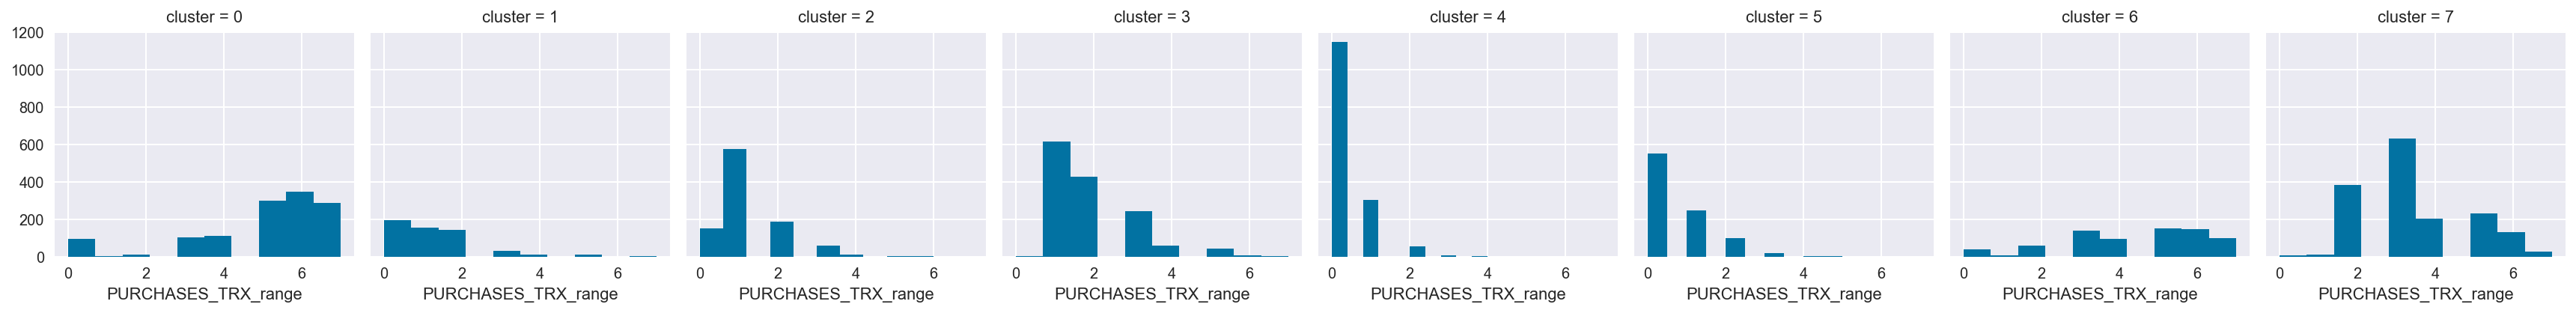

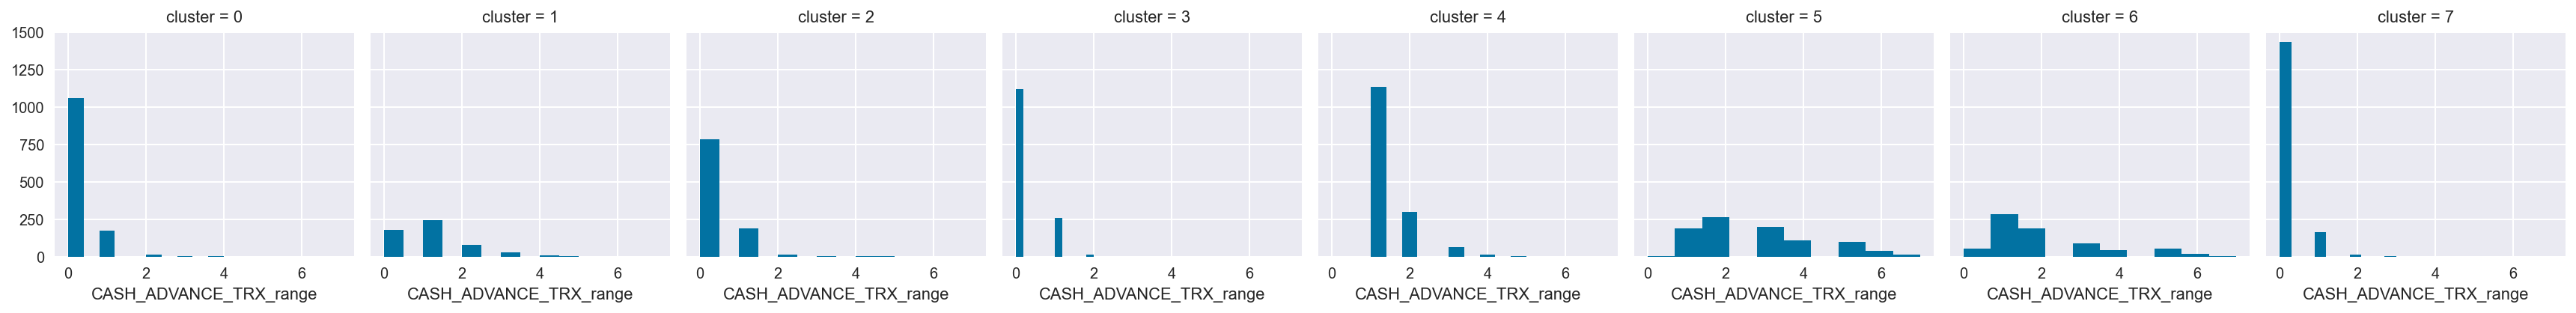

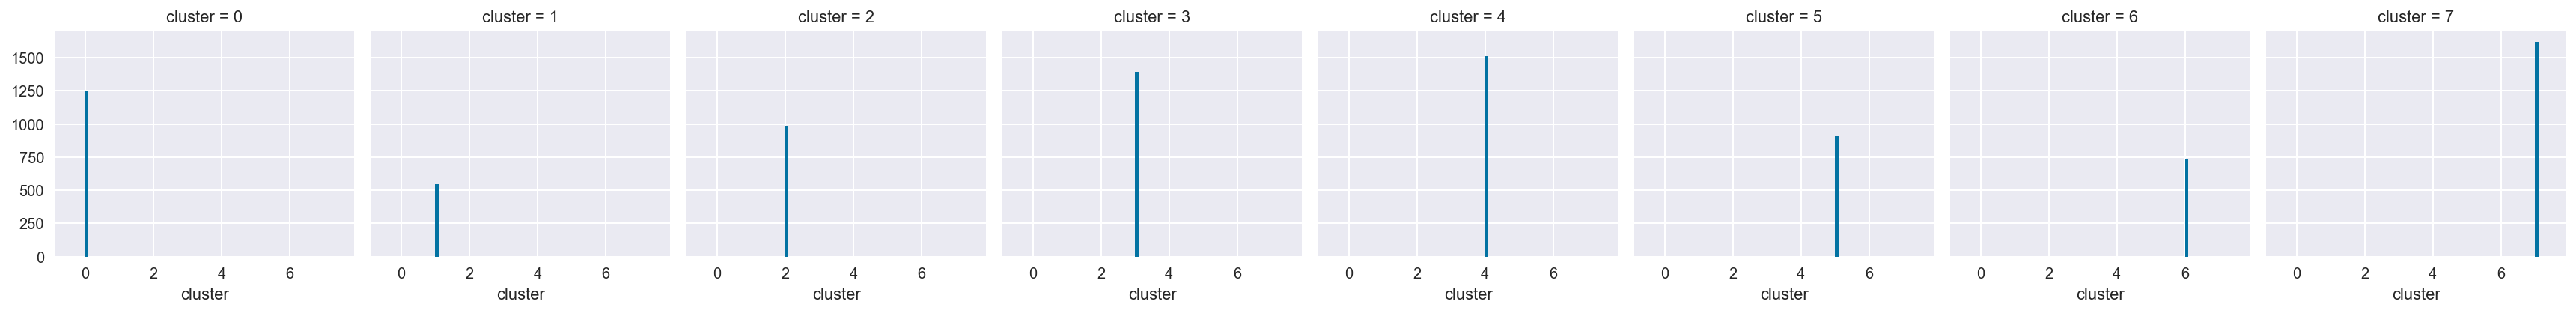

In [107]:
# раскомментируйте код для получения информации о распределениях признаков для каждого кластера
for c in clusters:
    grid = sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

#### Место для ваших выводов

Визуализируем кластеры, предварительно уменьшив размерность с помощью PCA до 2-х


In [108]:
pca = PCA(2)
pca_df = pca.fit_transform(X)
pca_df.shape

(8950, 2)

In [109]:
# Меняю имена столбцов и добавляю столбец с метками кластеризации
pca_df.columns = ['x', 'y']
pca_df['cluster'] = labels

In [110]:
pca_df

,x,y,cluster
0,-0.948378,-2.486937,3
1,-2.912296,2.172828,5
2,1.432314,0.645896,3
3,-0.740097,0.048019,3
4,-1.017032,-1.434760,3
...,...,...,...
8945,0.585497,-2.762741,1
8946,0.231479,-2.213528,1
8947,0.019907,-2.838942,1
8948,-2.735314,-2.616166,1


In [111]:
import plotly.express as px

In [112]:
fig = px.scatter(pca_df, 
                 x='x', 
                 y='y', 
                 color='cluster',
                 height=700,
                 width=1000,
                 title='Customers Segmentation based on their Credit Card usage behaviour.')

fig.update_layout(legend_orientation='h',
                  legend=dict(x=.5, xanchor='center'),
                  hovermode='x',
                  margin=dict(l=0, r=10, t=40, b=0))

fig.show()

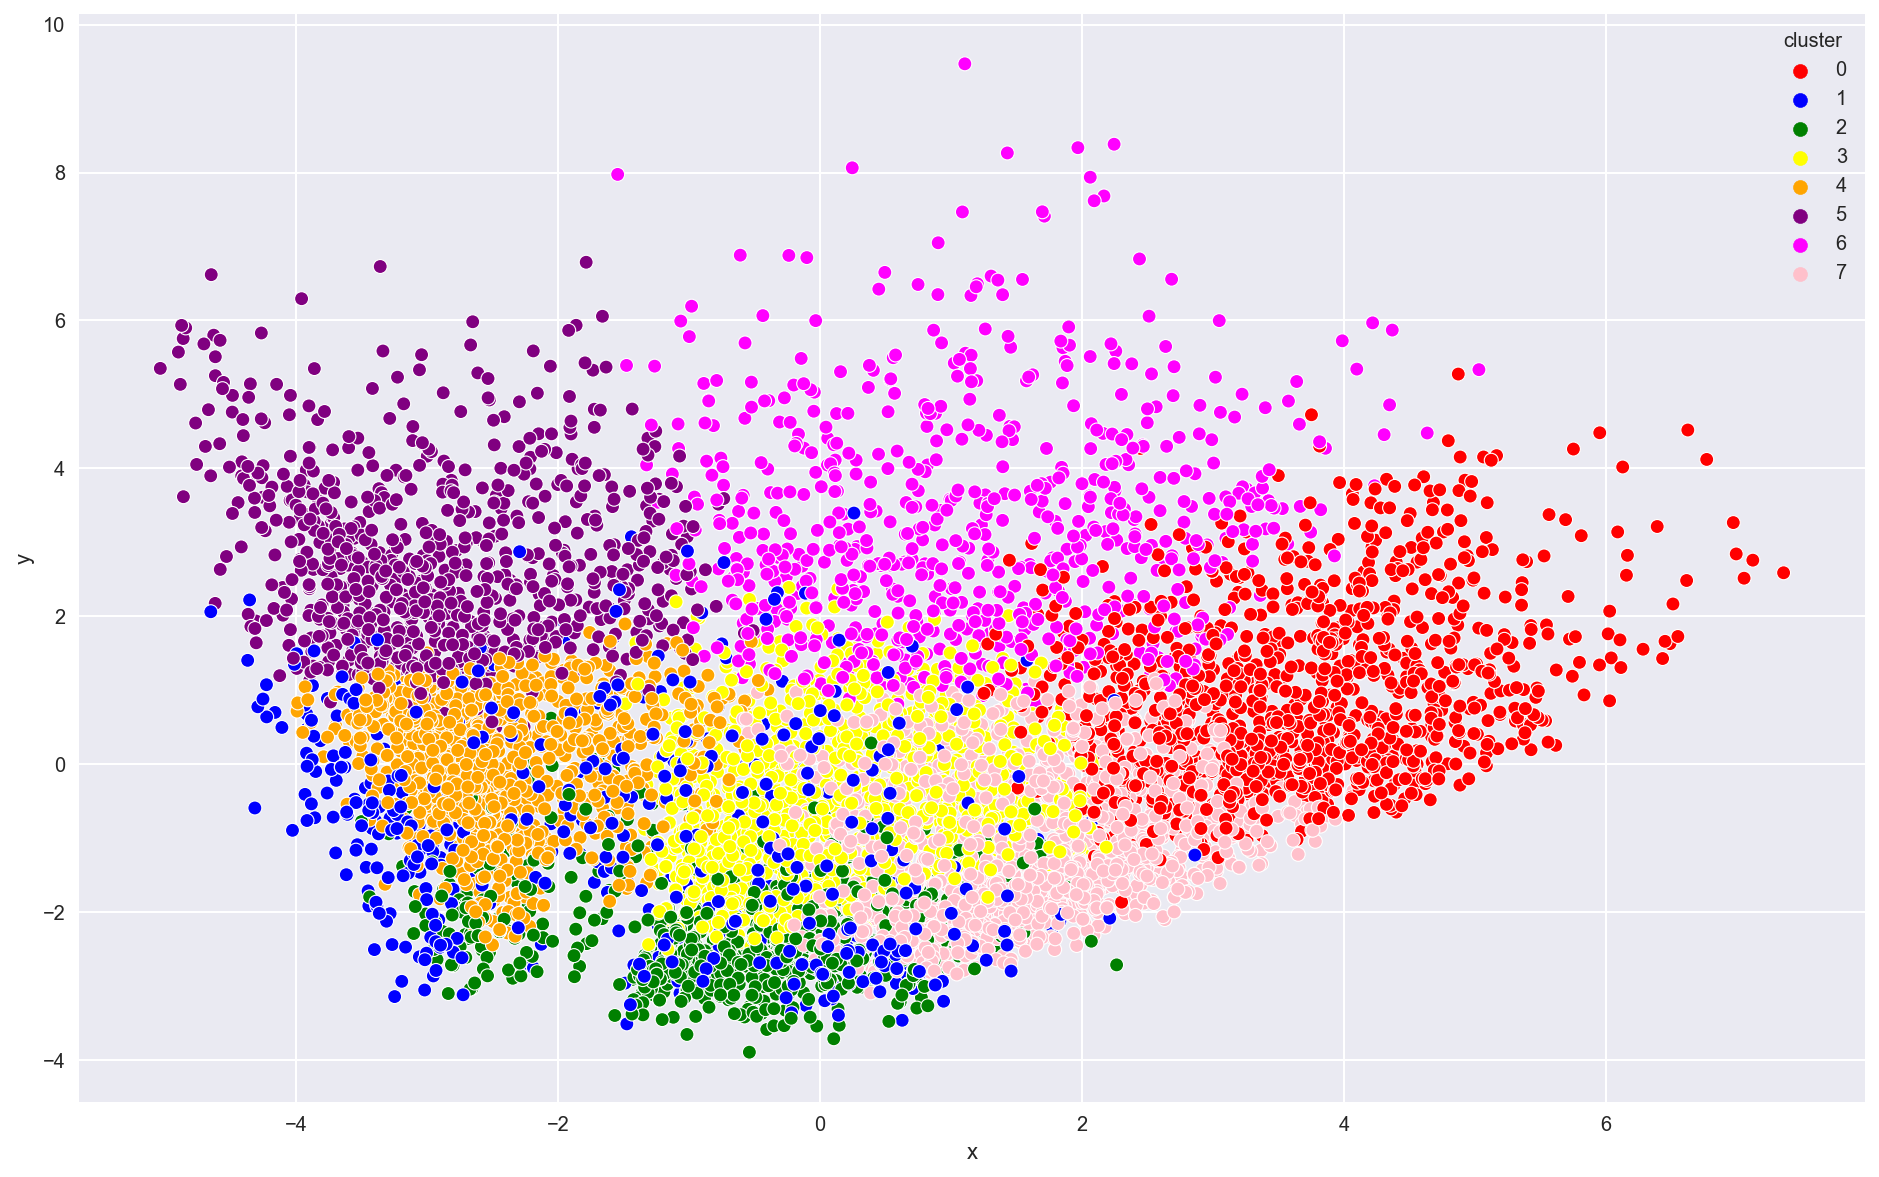

In [113]:
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'fuchsia', 'pink']
fig = plt.figure(figsize=(16, 10))
sns.scatterplot(data=pca_df, x='x', y='y', hue='cluster', palette=sns.color_palette(colors))
plt.show()

### Задача 8.3 
C помощью атрибута `explained_variance_ratio_` выведите процент объясненной дисперсии по обоим из осей. В качестве ответа внесите максимальное значение, округленное до десятых.

In [114]:
pca.explained_variance_ratio_

array([0.31642559, 0.22163255])

In [115]:
round(max(pca.explained_variance_ratio_), 1)

0.3

In [116]:
# Сколько всего информации смогли объяснить два компонента
print('Total variance:', sum(pca.explained_variance_ratio_))

Total variance: 0.5380581359395006


Эта визуализации мне вообще не понравилась, мои варианты выше намного лаконичнее

In [117]:
# x, y = X_PCA[:, 0], X_PCA[:, 1]

# colors = {0: 'red',
#           1: 'blue',
#           2: 'green', 
#           3: 'yellow', 
#           4: 'orange',  
#           5: 'purple',
#           6: 'fuchsia',
#           7: 'pink'}

# names = {i: f'cluster {i+1}' for i in range(k_clust)}
  
# df = pd.DataFrame({'x': x, 'y': y, 'label': labels})
# groups = df.groupby('label')

# fig, ax = plt.subplots(figsize=(18, 10))

# for name, group in groups:
#     ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
#             color=colors[name], label=names[name], mec='none')
#     ax.set_aspect('auto')
#     ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
#     ax.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')
    
# ax.legend()
# ax.set_aspect('auto')
# ax.set_title('Customers Segmentation based on their Credit Card usage bhaviour.')
# plt.show()

Как мы видим, результат достаточно неочевидный, для более красивой визуализации вычислим косинусоидальное расстояние от исходных данных и применим к ним PCA.

Напомним, что косинусоидальное расстояние имеет вид: $$1 - \frac{u  v}{||u||_2||v||_2}$$
В модуле `sklearn.metrics.pairwise` реализовано вычитаемое в данной разнице в функции `cosine_similarity` предлагается реализовать функцию `cos_dist` косинусоидального расстояния на основе данной встроенной функции.

In [118]:
def cos_dist(X):
     return 1 - cosine_similarity(X) # здесь реализация

In [119]:
dist = cos_dist(X)

pca = PCA(2)
pca_df = pca.fit_transform(dist)
pca_df.shape

(8950, 2)

In [120]:
# Результат снижения размерности преобразую в датафрейм и добавляю столбец с метками кластеризации
pca_df.columns=['x', 'y']
pca_df['cluster'] = labels

### Задача 8.4 
С помощью атрибута `explained_variance_ratio_` выведите процент объясненной дисперсии по обоим из осей после применения **косинусоидального значения**. В качестве ответа внесите максимальное значение, округленное до десятых.

In [121]:
round(max(pca.explained_variance_ratio_), 1)

0.6

In [122]:
fig = px.scatter(pca_df, 
                 x='x', 
                 y='y', 
                 color='cluster',
                 height=700,
                 width=1000,
                 title='Customers Segmentation based on their Credit Card usage behaviour.')

fig.update_layout(legend_orientation='h',
                  legend=dict(x=.5, xanchor='center'),
                  hovermode='x',
                  margin=dict(l=0, r=10, t=40, b=0))

fig.show()

In [123]:
# x, y = X_PCA[:, 0], X_PCA[:, 1]

# colors = {0: 'red',
#           1: 'blue',
#           2: 'green', 
#           3: 'yellow', 
#           4: 'orange',  
#           5:'purple',
#           6:'fuchsia',
#           7:'pink'}

# names = {i: f'cluster {i+1}' for i in range(k_clust)}
  
# df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
# groups = df.groupby('label')
# fig, ax = plt.subplots(figsize=(20, 13)) 

# for name, group in groups:
#     ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
#             color=colors[name],label=names[name], mec='none')
#     ax.set_aspect('auto')
#     ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
#     ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
# ax.legend()
# ax.set_title('Customers Segmentation based on their Credit Card usage bhaviour.')
# plt.show()

Визуализация получилась гораздо разборчивее!

### Задача 8.5
Что вы можете сказать о визуализации кластеров после преобразования с помощью косинусоидального расстояния:
* ничего не изменилось
* кластера стали сильнее различимы
* картина кластеров приняла форму эллипса
* картина кластеров  приняла форму квадрата


## Выводы
В данном задании мы на практике:
* определили оптимальное количество кластеров
* решили задачу кластеризации
* попробовали описать характерные зависимости для каждого кластера
* попробовали снизить размерность до 2-х мерной с помощью PCA
* преобразовали данные для лучшей визуализации с помощью косинусоидального расстояния.